In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


In [ ]:
bit_data=pd.read_csv("/content/drive/MyDrive/DM/bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv")
bit_data["date"]=pd.to_datetime(bit_data["Timestamp"],unit="s").dt.date
group=bit_data.groupby("date")
data=group["Close"].mean()

In [ ]:
bit_data.shape

(3778817, 9)

In [ ]:
bit_data.tail(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
3778807,1552434660,3857.21,3857.68,3857.21,3857.59,0.542492,2092.640913,3857.456219,2019-03-12
3778808,1552434720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-12
3778809,1552434780,3857.59,3858.17,3857.59,3858.17,0.297396,1147.336872,3857.939815,2019-03-12
3778810,1552434840,3858.17,3858.17,3858.17,3858.17,0.048400,186.735428,3858.170000,2019-03-12
3778811,1552434900,3857.80,3860.09,3857.59,3860.09,20.372100,78591.965693,3857.823469,2019-03-12
3778812,1552434960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-12
3778813,1552435020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-12
3778814,1552435080,3860.09,3861.05,3860.09,3861.05,0.378637,1461.770077,3860.606378,2019-03-12
3778815,1552435140,3860.18,3860.18,3859.74,3859.74,1.056403,4077.863045,3860.139080,2019-03-12
3778816,1552435200,3861.37,3862.01,3861.37,3861.95,0.198124,765.149137,3861.967464,2019-03-13


What I did here? I added a colum which is "date" and I converted "Timestamp" columns to date form.

In [ ]:
data.shape

(2627,)

In [ ]:
data.isnull().sum()

0

The goal is making a prediction of daily Close data. So we will predict "close" values of bitcoin data

**First I will use RNN to predict our data**

I am separating last 50 rows as the test data.

In [ ]:
close_train=data.iloc[:len(data)-50]
close_test=data.iloc[len(close_train):]

Here I will set our values between 0-1 in order to avoid domination of high values.

In [ ]:
#feature scalling (set values between 0-1)
close_train=np.array(close_train)
close_train=close_train.reshape(close_train.shape[0],1)
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
close_scaled=scaler.fit_transform(close_train)

Let's choose each 50 data as x-train and 51th as y-train

In [ ]:
timestep=50
x_train=[]
y_train=[]

for i in range(timestep,close_scaled.shape[0]):
    x_train.append(close_scaled[i-timestep:i,0])
    y_train.append(close_scaled[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) #reshaped for RNN
print("x_train shape= ",x_train.shape)
print("y_train shape= ",y_train.shape)

x_train shape=  (2527, 50, 1)
y_train shape=  (2527,)


Time to prepare and run our RNN method

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout,Flatten

regressor=Sequential()
#first RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True,input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.25))
#second RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#third RNN layer
regressor.add(SimpleRNN(512,activation="relu",return_sequences=True))
regressor.add(Dropout(0.35))
#fourth RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#fifth RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#convert the matrix to 1-line
regressor.add(Flatten())
#output layer
regressor.add(Dense(1))

regressor.compile(optimizer="adam",loss="mean_squared_error")
regressor.fit(x_train,y_train,epochs=20,batch_size=64)

Epoch 1/20
40/40 [==============================] - 28s 588ms/step - loss: 0.0059
Epoch 2/20
40/40 [==============================] - 25s 624ms/step - loss: 0.0021
Epoch 3/20
40/40 [==============================] - 23s 575ms/step - loss: 0.0019
Epoch 4/20
40/40 [==============================] - 23s 571ms/step - loss: 0.0016
Epoch 5/20
40/40 [==============================] - 23s 576ms/step - loss: 0.0012
Epoch 6/20
40/40 [==============================] - 25s 617ms/step - loss: 0.0012
Epoch 7/20
40/40 [==============================] - 23s 576ms/step - loss: 8.4125e-04
Epoch 8/20
40/40 [==============================] - 23s 577ms/step - loss: 7.1981e-04
Epoch 9/20
40/40 [==============================] - 23s 575ms/step - loss: 9.9456e-04
Epoch 10/20
40/40 [==============================] - 23s 575ms/step - loss: 7.5028e-04
Epoch 11/20
40/40 [==============================] - 23s 579ms/step - loss: 0.0011
Epoch 12/20
40/40 [==============================] - 23s 574ms/step - loss: 6.99

Now we are preparing our test data for prediction

In [ ]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [ ]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [ ]:
predicted_data=regressor.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

2/2 [==============================] - 1s 55ms/step


**What did we do???? We learnt our model with train data and then we tried to predict next 50 data (train data=50). Then we compared predictions with our test (real) data.**

In [ ]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

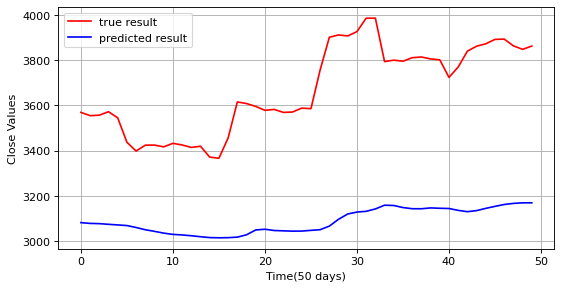

In [ ]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

Here we have the results of our prediction. As we can see on the chart that with RNN method we don't have a good result. So let's check LSTM method, then we can compare both results.

**Keep going with LSTM method**

I will use the same train and test data

In [ ]:
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten

model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

model.fit(x_train,y_train,epochs=60,batch_size=32)

Epoch 1/60
79/79 [==============================] - 3s 17ms/step - loss: 0.0055
Epoch 2/60
79/79 [==============================] - 1s 17ms/step - loss: 4.8617e-04
Epoch 3/60
79/79 [==============================] - 1s 17ms/step - loss: 3.5540e-04
Epoch 4/60
79/79 [==============================] - 1s 18ms/step - loss: 3.2127e-04
Epoch 5/60
79/79 [==============================] - 1s 17ms/step - loss: 2.8552e-04
Epoch 6/60
79/79 [==============================] - 1s 17ms/step - loss: 2.7023e-04
Epoch 7/60
79/79 [==============================] - 1s 17ms/step - loss: 2.6740e-04
Epoch 8/60
79/79 [==============================] - 1s 17ms/step - loss: 2.5090e-04
Epoch 9/60
79/79 [==============================] - 1s 17ms/step - loss: 2.4067e-04
Epoch 10/60
79/79 [==============================] - 1s 17ms/step - loss: 2.3961e-04
Epoch 11/60
79/79 [==============================] - 1s 17ms/step - loss: 2.1905e-04
Epoch 12/60
79/79 [==============================] - 1s 17ms/step - loss: 2.25

Keep going with test data

In [ ]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [ ]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

it's time to predict

In [ ]:
predicted_data=model.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

2/2 [==============================] - 0s 9ms/step


In [ ]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

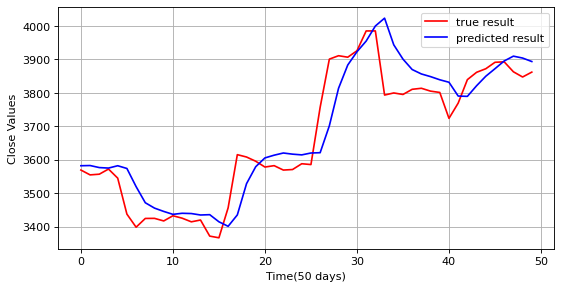

In [ ]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

* ** Conclusion**

When we compare the both results (RNN and LSTM) we can see that we have better prediction with LSTM. 

Up to here I was trying to show the differences between RNN - LSTM and how to use these methods on time series. 

If you have any question or I have any error please write me dirctly.
